# Potato

I'm done with naming notebooks!!!

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from scipy.stats import norm

# Data Generation from Wiener Velocity Profile

Because this is the simplest case!

Text(0.5, 1.0, 'Position Profiles')

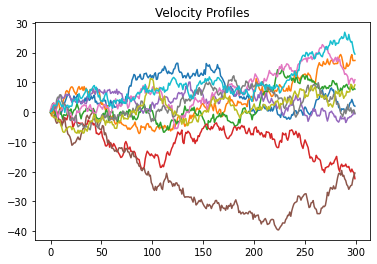

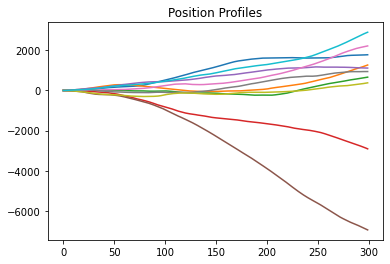

In [2]:
num_of_trajs = 200
length_of_trajs = 300
v_profiles = np.zeros((num_of_trajs, length_of_trajs))
x_profiles = np.zeros((num_of_trajs, length_of_trajs))
for i in range(num_of_trajs):
    a_profile = norm.rvs(scale=1, size=length_of_trajs)
    v_profiles[i,:] = np.cumsum(a_profile)
    x_profiles[i,:] = np.cumsum(v_profiles[i,:])
# Plot some sample v profiles and x profiles
trajs_to_plot = np.random.choice(num_of_trajs, 10)
plt.figure()
for i in trajs_to_plot:
    plt.plot(v_profiles[i,:])
plt.title('Velocity Profiles')
plt.figure()
for i in trajs_to_plot:
    plt.plot(x_profiles[i,:])
plt.title('Position Profiles')

# Find the Numerical FPCA

And let's call this basis NECTARINE.

In [3]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0.5, 1.0, 'Numerical FPCA basis of Position Profiles')

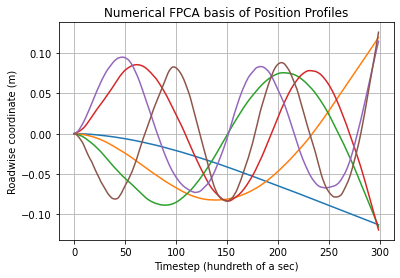

In [4]:
fdgrx = skfda.FDataGrid(x_profiles, np.arange(x_profiles.shape[1]))
fdgrv = skfda.FDataGrid(x_profiles, np.arange(x_profiles.shape[1]))
fpcax = FPCA(n_components=6)
fpcax.fit(fdgrx)
fpcax.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.title('Numerical FPCA basis of Position Profiles')

Get the covariance matrix, eigenvalues and eigenvectors

In [5]:
covx = fdgrx.cov().data_matrix
covx = covx.reshape(covx.shape[1:3])
evalx, evecx = np.linalg.eig(covx)
evalx = np.real(evalx)

Text(0.5, 1.0, 'Covariance matrix illustration')

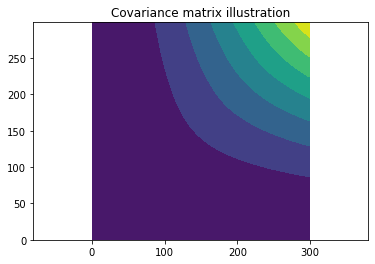

In [6]:
plt.contourf(covx)
plt.axis('equal')
plt.title('Covariance matrix illustration')

The eigenvalues ratio of x:

[9.68642574e-01 2.57613224e-02 3.87683192e-03 9.95796906e-04
 3.84483354e-04]


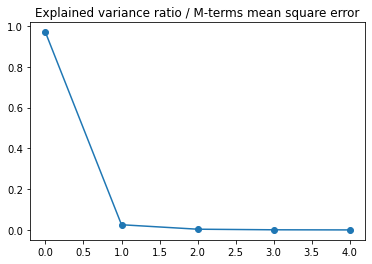

In [7]:
plt.plot(evalx[:5]/np.sum(evalx), '-o')
plt.title('Explained variance ratio / M-terms mean square error')
print(evalx[:5]/np.sum(evalx))

# Approximation of the Wiener process and its Integration

First we confirm the expansion of the Wiener process: $v(t) = \sum A_k \sqrt{2} cos((k-\frac{1}{2}\pi t))$ where $A_k$ follows a Gaussian random variable with variance $\frac{1}{((k-1/2)\pi)^2}$.

Text(0.5, 1.0, 'Reconstructed velocity profiles from 100 terms of expansion\nWithout restriction of time')

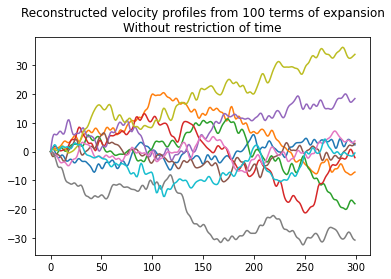

In [8]:
wiener = np.zeros((num_of_trajs, length_of_trajs))
wiener_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(wiener_terms):
    for i in range(num_of_trajs):
        Ak = norm.rvs(scale=1/((k+0.5)*np.pi))
        wiener[i,:] += np.sqrt(length_of_trajs) * Ak * np.sqrt(2) * np.sin((k+0.5)*np.pi*t)
for i in trajs_to_plot:
    plt.plot(wiener[i,:])
plt.title('Reconstructed velocity profiles from {:d} terms of expansion\nWithout restriction of time'.format(wiener_terms))

Compare this with the Wiener velocity profiles above, we confirm the expansion of Wiener process by sine functions. Now let us restrict $t$ to $[0,1]$, without any loss of generality. As a result, we don't have to multiply each term with $\sqrt{N}$ - the length of the trajectory.

Text(0.5, 1.0, 'Reconstructed velocity profiles from 100 terms of expansion\nWith time restricted to [0,1]')

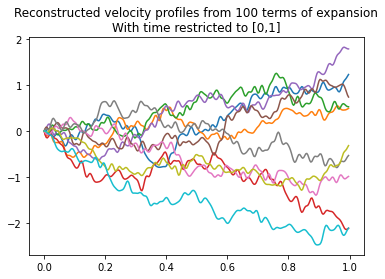

In [9]:
wiener = np.zeros((num_of_trajs, length_of_trajs))
wiener_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(wiener_terms):
    for i in range(num_of_trajs):
        Ak = norm.rvs(scale=1/((k+0.5)*np.pi))
        wiener[i,:] += Ak * np.sqrt(2) * np.sin((k+0.5)*np.pi*t)
for i in trajs_to_plot:
    plt.plot(t, wiener[i,:])
plt.title('Reconstructed velocity profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

We will try to construct the position profiles from $A_k$ and cosine: $x(t) = \sum_{k=1}^{+\infty} \frac{-\sqrt{2} A_k}{(k-1/2)\pi} (cos ((k-1/2)\pi t)-1)$.

Text(0.5, 1.0, 'Reconstructed position profiles from 100 terms of expansion\nWith time restricted to [0,1]')

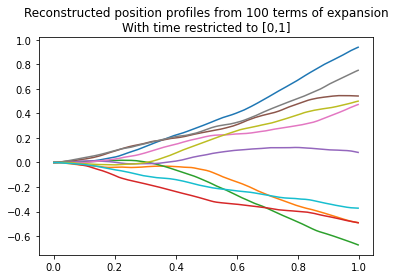

In [10]:
wienerint = np.zeros((num_of_trajs, length_of_trajs))
wienerint_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
# Generate Ak and Lambda
Ak = np.zeros((num_of_trajs, wienerint_terms))
Lamda = np.zeros((num_of_trajs,))
for k in range(wienerint_terms):
    for i in range(num_of_trajs):
        Ak[i,k] = norm.rvs(scale=1/((k+0.5)*np.pi))
        Lamda[i] += np.sqrt(2) * Ak[i,k] / ((k+0.5) * np.pi)
# Construct the position profiles
for i in range(num_of_trajs):
    for k in range(wienerint_terms):
        Aks = Ak[i,k]
        Lambd = Lamda[i]
        # wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) + (-1)**(k) * Lambd * 4./(np.pi * (2*k+1)) * np.cos((k+0.5)*np.pi*t)
        wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) * (np.cos((k+0.5)*np.pi*t)-1)
for i in trajs_to_plot:
    plt.plot(t, wienerint[i,:])
plt.title('Reconstructed position profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

Reconstruction of $1(t)$ in the odd cosine basis:

Text(0.5, 1.0, 'Expansion of $1(t)$ in 10 terms')

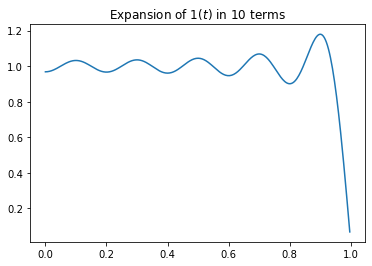

In [11]:
one_t = np.zeros((length_of_trajs))
one_terms = 10
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(one_terms):
    one_t += 4/(np.pi) * 1/(2*k + 1) * ((-1)**k) * (np.cos((k+0.5)*np.pi*t))
plt.plot(t, one_t)
plt.title("Expansion of $1(t)$ in {:d} terms".format(one_terms))

So the expansion seems correct, but note the strong attenuation near $t=1$.

Which will also be equal to:

$ = \sum_{k=1}^{+\infty} \left( \frac{-\sqrt{2} A_k}{(k-1/2)\pi} + (-1)^{k+1} \Lambda \frac{4}{\pi} \frac{1}{2k-1} \right) cos ((k-1/2)\pi t)$ 

Text(0.5, 1.0, 'Reconstructed position profiles from 100 terms of expansion\nWith time restricted to [0,1]')

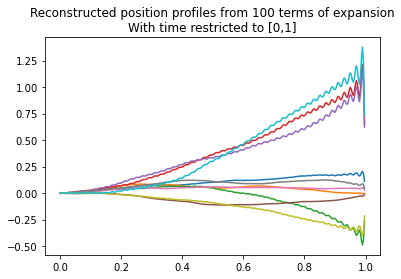

In [12]:
wienerint = np.zeros((num_of_trajs, length_of_trajs))
wienerint_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
# Generate Ak and Lambda
Ak = np.zeros((num_of_trajs, wienerint_terms))
Lamda = np.zeros((num_of_trajs,))
for k in range(wienerint_terms):
    for i in range(num_of_trajs):
        Ak[i,k] = norm.rvs(scale=1/((k+0.5)*np.pi))
        Lamda[i] += np.sqrt(2) * Ak[i,k] / ((k+0.5) * np.pi)
# Construct the position profiles
for i in range(num_of_trajs):
    for k in range(wienerint_terms):
        Aks = Ak[i,k]
        Lambd = Lamda[i]
        wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi) + (-1)**(k) * Lambd * 4./(np.pi * (2*k+1))) * np.cos((k+0.5)*np.pi*t)
        # wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) * (np.cos((k+0.5)*np.pi*t)-1)
for i in trajs_to_plot:
    plt.plot(t, wienerint[i,:])
plt.title('Reconstructed position profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

It seems that the approximation works, but we don't know for sure whether the approximation is reasonable. 

# The Transform Coefficient Covariance Matrix

Next, we verify the formula for the covariance matrix of the Transform Coefficient Covariance. We hope that this covariance matrix, when stripped off the off-diagonal elements, will reasonably approximate the covariance matrix, which yields hope that the KLT and OCT are asymptotically equivalent.

In [135]:
CNcn = np.zeros((wienerint_terms, wienerint_terms))
for k in range(wienerint_terms):
    for s in range(wienerint_terms):
        coeffs_k = (-np.sqrt(2) * Ak[:,k] / ((k+0.5)*np.pi))
        coeffs_s = (-np.sqrt(2) * Ak[:,s] / ((s+0.5)*np.pi))
        CNcn[k,s] = np.average(coeffs_k * coeffs_s)

In [146]:
32/((5*np.pi)**4)

0.000525618291439838

In [147]:
CNcn[:3,:3]

array([[ 3.03770466e-01, -1.42400727e-03, -3.71488012e-05],
       [-1.42400727e-03,  3.53391031e-03, -1.01131728e-04],
       [-3.71488012e-05, -1.01131728e-04,  5.66150144e-04]])

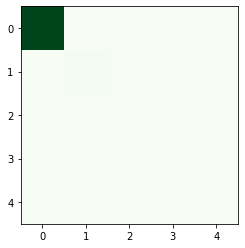

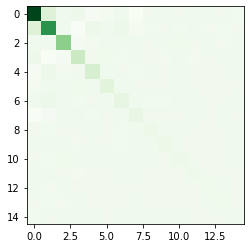

In [139]:
plt.figure()
plt.imshow(CNcn[:5,:5], cmap='Greens')
plt.figure()
plt.imshow(CNcn[5:20,5:20], cmap='Greens')

In [94]:
def delta(n,m):
    return 1 if n==m else 0

In [95]:
fourth_order_term = 0
for i in range(wienerint_terms):
    fourth_order_term += 1/((i+0.5)**4)
print('Fourth order term converges to {}'.format(fourth_order_term))

Fourth order term converges to 16.234848172350404


In [114]:
CNc = np.zeros((wienerint_terms, wienerint_terms))
for n in range(wienerint_terms):
    for m in range(wienerint_terms):
        # Note that we have discarded the fourth order term. 
        CNc[n,m] = 1/(((np.pi)**2) * (n+0.5) * (m+0.5)) * ((1 * delta(n,m) / (((np.pi)**2) * ((n+0.5)**2))) + 2 * (((-1)**(m)) / (((np.pi)**3) * ((n+0.5)**3)) + ((-1)**(n)) / (((np.pi)**3) * ((m+0.5)**3))))

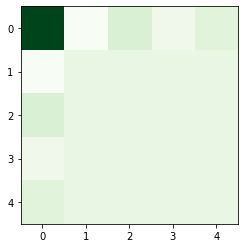

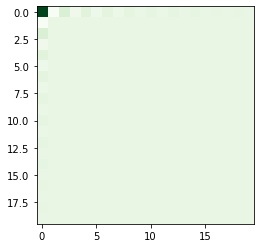

In [115]:
plt.figure()
plt.imshow(CNc[:5,:5], cmap='Greens')
plt.figure()
plt.imshow(CNc[:20,:20], cmap='Greens')

In essence, the top-left elements of the covariance matrix dominates rather than the main-diagonal. Hence, because of the presence of $\Lambda$, the main diagonal won't dominate all off-diagonal elements. Without $\Lambda$, it is easy to conclude that the OCT coincides with the KLT.

Here is a shameless effort to calculate the eigenvectors of the above covariance matrix:

In [89]:
eigvalCNc, eigvecCNc = np.linalg.eig(CNc) # the analytical version
eigvalCNcn, eigvecCNcn = np.linalg.eig(CNcn) # the numerical version

This is the eigenvectors of the analytical covariance matrix:

KLT 1 lnr cmbn forml: [-0.94670242  0.21698985 -0.13823195]
KLT 2 lnr cmbn forml: [-0.32155392 -0.67999735  0.38109428]
KLT 3 lnr cmbn forml: [ 0.01886614 -0.69757205 -0.4832347 ]
KLT 4 lnr cmbn forml: [ 0.00091996 -0.06011594  0.76991882]
KLT 5 lnr cmbn forml: [-0.00088944  0.01571921 -0.09038395]
KLT 6 lnr cmbn forml: [-0.00010572  0.00629135 -0.03048042]
KLT 7 lnr cmbn forml: [ 0.00016217 -0.00281943  0.01379799]
KLT 8 lnr cmbn forml: [ 2.66189732e-05 -1.55018171e-03  7.12594813e-03]
KLT 9 lnr cmbn forml: [-4.95455088e-05  8.62583372e-04 -4.12797287e-03]
KLT 10 lnr cmbn forml: [ 9.67903025e-06 -5.54941418e-04  2.52471690e-03]


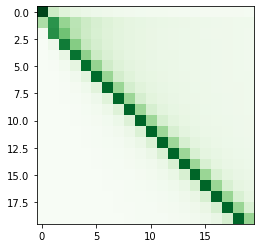

In [154]:
for i in range(10):
    print('KLT {:d} lnr cmbn forml: {}'.format(i+1, eigvecCNc[:3,i]))
plt.imshow(eigvecCNc.T, cmap='Greens')
plt.imshow(np.abs(eigvecCNc[:20,:20]).T, cmap='Greens')

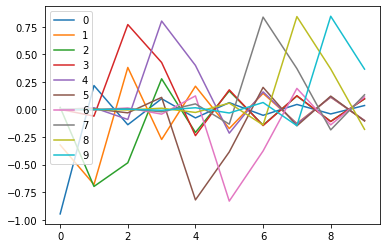

In [153]:
for i in range(10):
    plt.plot(eigvecCNc[:10,i], label=str(i))
plt.legend()

And this is the eigenvector of the numerical covariance matrix:

KLT 1 lnr cmbn forml: [ 0.98040889 -0.13990088  0.07870206]
KLT 2 lnr cmbn forml: [-0.19669518 -0.73131435  0.37724218]
KLT 3 lnr cmbn forml: [ 0.00980279 -0.66502225 -0.49617074]
KLT 4 lnr cmbn forml: [ 0.00253197 -0.05569727  0.77717798]
KLT 5 lnr cmbn forml: [ 0.00226876 -0.01329493 -0.02773986]
KLT 6 lnr cmbn forml: [-0.00018737 -0.00542731  0.01851174]
KLT 7 lnr cmbn forml: [ 0.00059495 -0.00362659  0.01212832]
KLT 8 lnr cmbn forml: [ 0.000605   0.0026063 -0.0007052]
KLT 9 lnr cmbn forml: [-0.00082781 -0.00329672  0.00310205]
KLT 10 lnr cmbn forml: [-0.00022708 -0.00306738 -0.0013068 ]


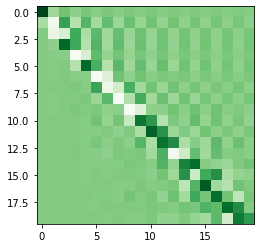

In [91]:
for i in range(10):
    print('KLT {:d} lnr cmbn forml: {}'.format(i+1, eigvecCNcn[:3,i]))
plt.imshow(eigvecCNcn.T, cmap='Greens')
plt.imshow(eigvecCNcn[:20,:20].T, cmap='Greens')

**If the OCT coincides with KLT, we would expect a single diagonal matrix. But the above image shows that the eigenvectors form by "smuding together" two or three consecutive cosine basis**. This is strange and quite totally unexpected???

Let's see if we can get the KLT from combining these or not

In [29]:
klt_attempt = np.zeros((5,length_of_trajs))
t = np.arange(length_of_trajs)/length_of_trajs
max_oct_basis_to_add = 100
for i in range(klt_attempt.shape[0]):
    for j in range(max_oct_basis_to_add):
        klt_attempt[i,:] += eigvecCNc[j,i] * np.cos((j+0.5)*np.pi*t)

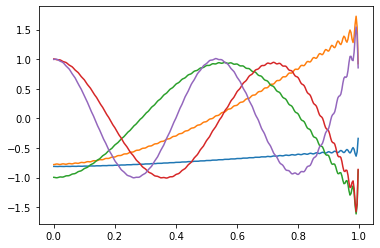

In [30]:
for i in range(klt_attempt.shape[0]):
    plt.plot(t, klt_attempt[i,:])

In [116]:
CNcn[:3,:3]

array([[ 0.53692938, -0.07284492,  0.04113528],
       [-0.07284492,  0.0252413 , -0.01256553],
       [ 0.04113528, -0.01256553,  0.00770877]])

In [117]:
CNc[:3,:3]

array([[ 5.82529462e-01, -6.71303543e-02,  4.21619936e-02],
       [-6.71303543e-02,  3.06557210e-04,  4.04847675e-04],
       [ 4.21619936e-02,  4.04847675e-04,  3.96656745e-04]])